In [11]:
from qiskit import QuantumCircuit, execute, quantum_info
from qiskit.visualization import plot_histogram
from qiskit_ionq import IonQProvider

In [12]:
import numpy as np
import random
from math import pi
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power
from PIL.Image import new as newimage, Image

In [13]:
provider = IonQProvider(token="YhJn5ic270pMZQX2xuwt2Zs4S500TmYR")

In [14]:
def make_line (length):
    # determine the number of bits required for at least `length` bit strings
    n = int(np.ceil(np.log(length)/np.log(2)))
    # start with the basic list of bit values
    line = ['0','1']
    # each application of the following process double the length of the list,
    # and of the bit strings it contains
    for j in range(n-1):
        # this is done in each step by first appending a reverse-ordered version of the current list
        line = line + line[::-1]
        # then adding a '0' onto the end of all bit strings in the first half
        for j in range(int(len(line)/2)):
            line[j] += '0'
        # and a '1' onto the end of all bit strings in the second half
        for j in range(int(len(line)/2),int(len(line))):
            line[j] += '1'
    return line

In [15]:
def make_grid(L):
    
    line = make_line( L )
    
    grid = {}
    for x in range(L):
        for y in range(L):
            grid[ line[x]+line[y] ] = (x,y)
    
    return grid

In [16]:
def img2circuit(img, grid):
    
    n = len( list(grid.keys())[0] )
        
    state = [0]*(2**n)
    
    H = 0
    for bitstring in grid:
        h = img[grid[bitstring]] / 256
        state[ int(bitstring,2) ] = np.sqrt(h)
        H += h
        
    for j,amp in enumerate(state):
        state[ j ] = amp/np.sqrt(H)
        
    qc = QuantumCircuit(n,n)
    qc.initialize( state, qc.qregs )
        
    return qc

In [17]:
def circuit2img(L,qc,grid,backend,shots):
    
    # get the number of qubits from the circuit
    n = qc.num_qubits
    
    # construct a circuit to perform z measurements
    for j in range(n):
        qc.measure(j,j)

    #run the circuit on the supplied backend
    counts = execute(qc,backend,shots=shots).result().get_counts() 
    
    max_h = np.log( max( counts.values() ) )
    
    # loop over all bit strings in `counts`, and set the corresponding count to be
    # the value for the corresponding coordinate. Values are rescaled to ensure
    # that the largest is 1, and that none is less than zero.
    img = np.zeros((L, L), dtype=np.uint8)
    for bitstring in counts:
        if bitstring in grid:
            if counts[bitstring] > 0:
                img[ grid[bitstring] ] = np.log(counts[bitstring]+1) * 256 / max_h
    
    return img

In [18]:
def generate_seed(L,num=5):
    # generate a noise map of `num` randomly chosen points, each with randomly chosen values
    image = np.zeros((L, L), dtype=np.uint8)
    
    for _ in range(num - 1):
        x = random.randint(0,L-1)
        y = random.randint(0,L-1)
        image[x,y] = random.random() * 256
    
    x = random.randint(0,L-1)
    y = random.randint(0,L-1)
    image[x,y] = 255
        
    return image

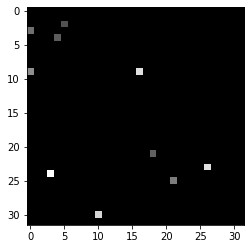

In [19]:
L = 32
grid = make_grid(L)
seed = generate_seed(L, 10)
plt.imshow(seed, cmap = 'gray')

In [ ]:
qc = img2circuit(seed,grid)
qc.ry(pi/6,qc.qregs[0])
qc.rx(pi/6,qc.qregs[0])
sq = circuit2img(L,qc,grid,provider.get_backend("ionq_qpu"),shots=640)
plt.imshow(sq, cmap='gray')

In [ ]:
plt.imshow([[1 if x > 0 else -1 for x in arr] for arr in sq])

In [ ]:
def shuffle_img (img,grid):
    
    # determine the number of qubits
    n = int( np.log(len(grid))/np.log(2) )
    
    # randomly choose a way to shuffle the bit values in the string
    shuffle = [j for j in range(n)]
    random.shuffle(shuffle)
    
    # for each bit string, determine and record the pair of positions
    # * `pos`: the position correspoding to the bit string in the given `grid`
    # * `new_pos`: the position corresponding to the shuffled version of the bit string
    remap = {}
    for bitstring in grid:
        
        shuffledstring = ''.join([bitstring[j] for j in shuffle])

        pos = grid[bitstring]
        new_pos = grid[shuffledstring]
        
        remap[pos] = new_pos
        
        
    # create and return `new_img`, in which each point is moved from `pos` to `new_pos`
    new_img = np.zeros((L, L), dtype=np.uint8)
    for (x, arr) in enumerate(img):
        for (y, val) in enumerate(arr):
            new_img[remap[x,y]] = img[x,y]
        
    return new_img

In [ ]:
def simplify_shuffle(img, grid):
    return [[1 if x > 0 else -1 for x in arr] for arr in shuffle_img(img, grid)]

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(simplify_shuffle(sq, grid))
axs[0,1].imshow(simplify_shuffle(sq, grid))
axs[1,0].imshow(simplify_shuffle(sq, grid))
axs[1,1].imshow(simplify_shuffle(sq, grid))

In [ ]:
size = 128
frames = 128
iterations_per_frame = 4000

Lattice = np.zeros((size, size), dtype=int)

for x in range(size//L):
    for y in range(size//L):
            new_img = simplify_shuffle(sq, grid)
            for x2 in range(L):
                for y2 in range(L):
                    Lattice[x*L+x2,y*L+y2] = new_img[x2][y2]

plt.imshow(Lattice)

In [ ]:
fig = plt.figure()

def update(i):
    for _ in range(iterations_per_frame):
        x, y = random.randint(0,size-1), random.randint(0,size-1)
        
        C = Lattice[y,x]
        N = Lattice[(y-1)%size,x]
        E = Lattice[y,(x+1)%size]
        S = Lattice[(y+1)%size,x]
        W = Lattice[y,(x-1)%size]

        H = int(C==N) + int(C==E) + int(C==S) + int(C==W) # low H corresponds to high energy
        if H < 1:
            Lattice[y,x] *= -1
        elif random.uniform(0,1) < 2**(-4*(H-2)):
            Lattice[y,x] *= -1

for i in range(1,frames):
    update(i)

plt.imshow(Lattice)

In [ ]:
Image = [[(0,0,0) for x in range(size)] for y in range(size)]


# delete lone pixels
for x in range(size):
    for y in range(size):
        C = Lattice[y][x]
        N = Lattice[(y-1)%size][x]
        E = Lattice[y][(x+1)%size]
        S = Lattice[(y+1)%size][x]
        W = Lattice[y][(x-1)%size]

        H = (C==N) + (C==E) + (C==S) + (C==W)

        if H < 1: Lattice[y][x] *= -1

        if Lattice[y][x] == 1:
            Image[y][x] = (180,255,0)
        else:
            Image[y][x] = (0,0,200)

plt.imshow(Image)
fileName = 'map.jpg'
plt.savefig(fileName)

# Implementing Quantum Blur

In [ ]:
def normalize(ket):
    """
    Normalizes the given statevector.
    
    Args:
        ket (list or array_like)
    
    Returns:
        ket (list or array_like)
    """
    N = 0
    for amp in ket:
        N += amp*amp.conjugate()
    for j,amp in enumerate(ket):
        ket[j] = float(amp)/math.sqrt(N)
    return ket

def _kron(vec0,vec1):
    """
    Calculates the tensor product of two vectors.
    """
    new_vec = []
    for amp0 in vec0:
        for amp1 in vec1:
            new_vec.append(amp0*amp1)
    return new_vec

def _get_size(height):
    """
    Determines the size of the grid for the given height map.
    """
    Lx = 0
    Ly = 0
    for (x,y) in height:
        Lx = max(x+1,Lx)
        Ly = max(y+1,Ly)
    return Lx,Ly

def _image2heights(image):
    """
    Converts an rgb image into a list of three height dictionaries, one for
    each colour channgel.
    """
    Lx,Ly = image.size
    heights = [{} for j in range(3)]
    for x in range(Lx):
        for y in range(Ly):
            rgb = image.getpixel((x,y))
            for j in range(3):
                heights[j][x,y] = rgb[j]

    return heights

In [ ]:
def make_line ( length ):
    """
    Creates a list of bit strings of at least the given length, such
    that the bit strings are all unique and consecutive strings
    differ on only one bit.
    
    Args:
        length (int): Required length of output list.
    
    Returns:
        line (list): List of 2^n n-bit strings for n=⌊log_2(length)⌋
    """
    
    # number of bits required
    n = int(math.ceil(math.log(length)/math.log(2)))
    
    # iteratively build list
    line = ['0','1']
    for j in range(n-1):
        # first append a reverse-ordered version of the current list
        line = line + line[::-1]
        # then add a '0' onto the end of all bit strings in the first half
        for j in range(int(float(len(line))/2)):
            line[j] += '0'
        # and a '1' for the second half
        for j in range(int(float(len(line))/2),int(len(line))):
            line[j] += '1'
            
    return line

def make_grid(Lx,Ly=None):
    """
    Creates a dictionary that provides bit strings corresponding to
    points within an Lx by Ly grid.
    
    Args:
        Lx (int): Width of the lattice (also the height if no Ly is
            supplied).
        Ly (int): Height of the lattice if not Lx.
    
    Returns:
        grid (dict): Dictionary whose values are points on an
            Lx by Ly grid. The corresponding keys are unique bit
            strings such that neighbouring strings differ on only
            one bit.
        n (int): Length of the bit strings
        
    """
    # set Ly if not supplied
    if not Ly:
        Ly = Lx
    
    # make the lines
    line_x = make_line( Lx )
    line_y = make_line( Ly )
    
    # make the grid
    grid = {}
    for x in range(Lx):
        for y in range(Ly):
            grid[ line_x[x]+line_y[y] ] = (x,y)
            
    # determine length of the bit strings
    n = len(line_x[0]+line_y[0])
            
    return grid, n



In [ ]:
def height2circuit(height, log=False, eps=1e-2):
    """
    Converts a dictionary of heights (or brightnesses) on a grid into
    a quantum circuit.
    
    Args:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are positive numbers of
            any type.
        log (bool): If given, a logarithmic encoding is used.
            
    Returns:
        qc (QuantumCircuit): A quantum circuit which encodes the
            given height dictionary.
    """
    # get bit strings for the grid
    Lx,Ly = _get_size(height)
    grid, n = make_grid(Lx,Ly)
    
    # create required state vector
    state = [0]*(2**n)
    if log:
        # normalize heights
        max_h = max(height.values())
        height = {pos:float(height[pos])/max_h for pos in height}
        # find minimum (not too small) normalized height
        min_h = min([height[pos] for pos in height if height[pos] > eps])
        # this minimum value defines the base
        base = 1.0/min_h
    for bitstring in grid:
        (x,y) = grid[bitstring]
        if (x,y) in height:
            h = height[x,y]
            if log:
                state[ int(bitstring,2) ] = math.sqrt(base**(float(h)/min_h))
            else:
                state[ int(bitstring,2) ] = math.sqrt( h )
    state = normalize(state)
        
    # define and initialize quantum circuit            
    qc = QuantumCircuit(n)
    qc.initialize(state,range(n))
    qc.name = '('+str(Lx)+','+str(Ly)+')'

    return qc

def image2circuits(image, log=False):
    """
    Converts an image to a set of three circuits, with one corresponding to
    each RGB colour channel.

    Args:
        image (Image): An RGB encoded image.
        log (bool): If given, a logarithmic encoding is used.

    Returns:
        circuits (list): A list of quantum circuits encoding the image.
    """

    heights = _image2heights(image)

    circuits = []
    for height in heights:
        circuits.append( height2circuit(height, log=log) )

    return circuits

In [ ]:
def _heights2image(heights):
    """
    Constructs an image from a set of three height dictionaries, one for each
    colour channel.
    """
    Lx,Ly = _get_size(heights[0])
    h_max = [max(height.values()) for height in heights]

    image = newimage('RGB',(Lx,Ly))
    for x in range(Lx):
        for y in range(Ly):
            rgb = []
            for j,height in enumerate(heights):
                if (x,y) in height:
                    h = float(height[x,y])/h_max[j]
                else:
                    h = 0
                rgb.append( int(255*h) )
            image.putpixel((x,y), tuple(rgb) )

    return image

def probs2height(probs, size=None, log=False):
    """
    Extracts a dictionary of heights (or brightnesses) on a grid from
    a set of probabilities for the output of a quantum circuit into
    which the height map has been encoded.
    
    Args:
        probs (dict): A dictionary with results from running the circuit.
            With bit strings as keys and either probabilities or counts as
            values.
        size (tuple): Size of the height map to be created. If not given,
            the size is deduced from the number of qubits (assuming a
            square image).
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are floats in the
            range 0 to 1.
    """
    
    # get grid info
    if size:
        (Lx,Ly) = size
    else:
        Lx = int(2**(len(list(probs.keys())[0])/2))
        Ly = Lx
    grid,_ = make_grid(Lx,Ly)
    
    # set height to probs value, rescaled such that the maximum is 1
    max_h = max( probs.values() )   
    height = {(x,y):0.0 for x in range(Lx) for y in range(Ly)}
    for bitstring in probs:
        if bitstring in grid:
            height[grid[bitstring]] = float(probs[bitstring])/max_h
         
    # take logs if required
    if log:
        min_h = min([height[pos] for pos in height if height[pos] !=0])
        alt_min_h = min([height[pos] for pos in height])
        base = 1/min_h
        for pos in height:
            if height[pos]>0:
                height[pos] = max(math.log(height[pos]/min_h)/math.log(base),0)
            else:
                height[pos] = 0.0
                        
    return height

def circuit2probs(qc):
    """
    Runs the given circuit, and returns the resulting probabilities.
    """
    # separate circuit and initialization
    new_qc = qc.copy()
    new_qc.data = []
    initial_ket = [1]
    for gate in qc.data:
        if gate[0].name=='initialize':
            initial_ket = _kron(initial_ket,gate[0].params)
        else:
            new_qc.data.append(gate)
    # if there was no initialization, use the standard state        
    if len(initial_ket)==1:
        initial_ket = [0]*2**qc.num_qubits
        initial_ket[0] = 1       
    # then run it
    ket = quantum_info.Statevector(initial_ket)
    ket = ket.evolve(new_qc)
    probs = ket.probabilities_dict()
    
    return probs

def circuit2height(qc, log=False):
    """
    Extracts a dictionary of heights (or brightnesses) on a grid from
    the quantum circuit into which it has been encoded.
    
    Args:
        qc (QuantumCircuit): A quantum circuit which encodes a height
            dictionary. The name attribute should hold the size of
            the image to be created (as a tuple cast to a string).
        log (bool): If given, a logarithmic decoding is used.
            
    Returns:
        height (dict): A dictionary in which keys are coordinates
            for points on a grid, and the values are floats in the
            range 0 to 1.
    """
    
    probs = circuit2probs(qc)
    try:
        # get size from circuit
        size = eval(qc.name)
    except:
        # if not in circuit name, infer it from qubit number
        L = int(2**(qc.num_qubits/2))
        size = (L,L)
    return probs2height(probs, size=size, log=log)

def circuits2image(circuits, log=False):
    """
    Extracts an image from list of circuits encoding the RGB channels.

    Args:
        circuits (list): A list of quantum circuits encoding the image.
        log (bool): If given, a logarithmic decoding is used.

    Returns:
        image (Image): An RGB encoded image.
    """

    heights = []
    for qc in circuits:
        heights.append( circuit2height(qc, log=log) )

    return _heights2image(heights)



In [ ]:
def partial_x(qc,fraction):
    for j in range(qc.num_qubits):
        qc.rx(np.pi*fraction,j)

In [ ]:
from PIL import Image

ac = Image.open('wall.png')

ac = ac.resize((IMG_SIZE, IMG_SIZE))

ac

In [ ]:

qcs_circ = image2circuits(ac)

for qc in qcs_circ:
    partial_x(qc,0.05)

ground = circuits2image(qcs_circ)

        
qcs = image2circuits(ac, log=True)

for qc in qcs:
    partial_x(qc, 0.08)

wall = circuits2image(qcs, log=True)



In [ ]:
board = [wall if val == 1 else ground for arr in REAL_VALS for val in arr]

In [ ]:
blank_image = Image.new("RGB", (WIDTH*IMG_SIZE, HEIGHT*IMG_SIZE))
col = 0
row = 0
for i, image in enumerate(board):
    if row >= WIDTH:
        col += 1
        row = 0
    blank_image.paste(image, (row*IMG_SIZE, col*IMG_SIZE))
    row += 1

plt.axis('off')
plt.imshow(blank_image)

plt.savefig("sample_map.png")